In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammedabdeldayem/the-fake-or-real-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-fake-or-real-dataset


In [2]:
import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Reshape

# Define dataset path (automatically mounted by Kaggle)
DATASET_PATH = "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training"

In [4]:
def pitch_shift_audio(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)


In [5]:
def spec_augment(mel_spectrogram, time_mask_param=10, freq_mask_param=10):
    mel_spectrogram = mel_spectrogram.copy()

    # Time Masking
    t = mel_spectrogram.shape[1]
    t0 = np.random.randint(0, max(1, t - time_mask_param))
    mel_spectrogram[:, t0:t0 + time_mask_param] = 0

    # Frequency Masking
    f = mel_spectrogram.shape[0]
    f0 = np.random.randint(0, max(1, f - freq_mask_param))
    mel_spectrogram[f0:f0 + freq_mask_param, :] = 0

    return mel_spectrogram





In [6]:
def extract_features(file_path, sr=22050, n_mfcc=40,augument=True):
    y, sr = librosa.load(file_path, sr=sr)

    if augument:
        y = pitch_shift_audio(y, sr, n_steps=np.random.randint(-2, 3))
    
    # Compute Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    if augument:
        mel_spec = spec_augment(mel_spec)
    # Compute MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Normalize and combine features
    features = np.vstack([mel_spec[:40], mfcc])
    
    return features.T  # Transpose for shape (Time, Features)

# Load dataset (Real and Fake samples)
def load_dataset(directory,augument=True):
    X, y = [], []
    for label in ["real", "fake"]:
        path = os.path.join(directory, label)
        for file in os.listdir(path):
            if file.endswith(".wav"):
                features = extract_features(os.path.join(path, file),augument=False)
                X.append(features)
                y.append(label)

                if augument:
                    aug_features=extract_features(os.path.join(path,file),augument=True)
                    X.append(aug_features)
                    y.append(label)

    
    
    return np.array(X), np.array(y)

# Load the dataset
X, y = load_dataset(DATASET_PATH)
print(X.shape)
print(y.shape)


(27912, 87, 80)
(27912,)


In [7]:
X[0]

array([[-50.475937  , -51.58074   , -47.681595  , ...,   1.1384208 ,
         -1.5261846 ,  -5.403734  ],
       [-48.444313  , -55.723946  , -51.70837   , ...,  -1.6943749 ,
         -0.5417472 ,  -2.3141026 ],
       [-49.069756  , -54.31234   , -49.027637  , ...,  -2.3710332 ,
          0.69861233,  -0.27954173],
       ...,
       [-45.850918  , -45.041656  , -44.369125  , ...,   6.2815857 ,
          4.67443   ,  -3.626313  ],
       [-43.559967  , -44.08969   , -40.361164  , ...,   3.5999193 ,
          2.7419987 ,  -1.8833438 ],
       [-47.377266  , -45.131626  , -40.085205  , ...,   2.1682642 ,
          1.5171438 ,  -1.528726  ]], dtype=float32)

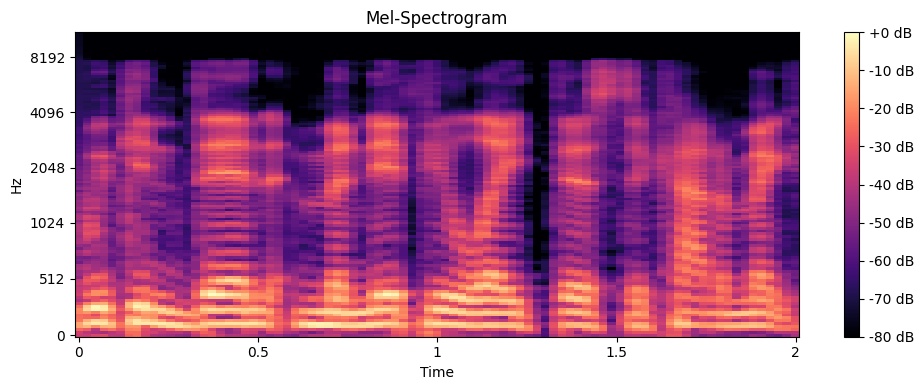

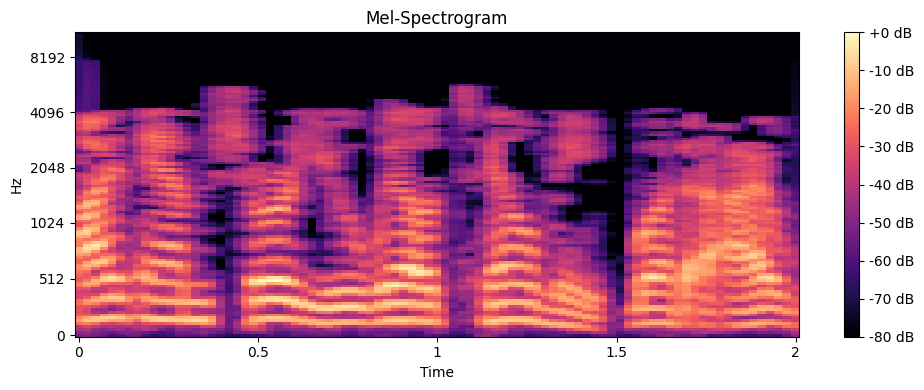

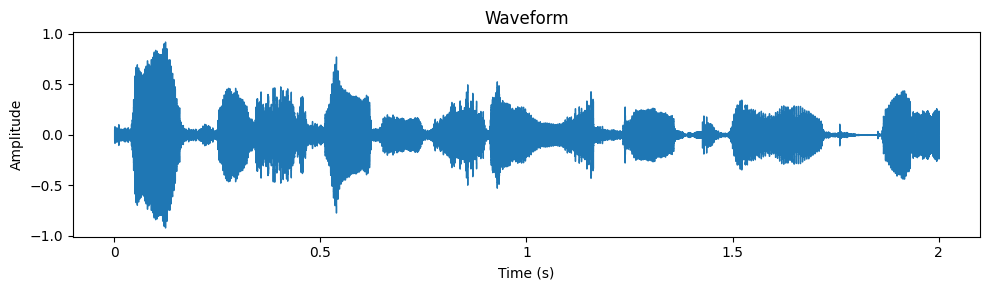

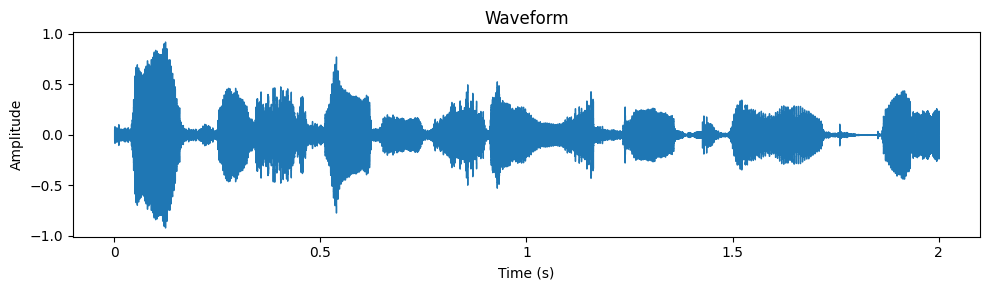

In [8]:
def mel_specs(file_path,sr=22050):
    y,sr=librosa.load(file_path,sr=sr);
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.show()
mel_specs('/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real/file10003.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav')
mel_specs('/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/fake/file10009.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav')


def plot_waveform(file_path):
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

plot_waveform('/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real/file10006.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav')
plot_waveform('/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real/file10006.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav')

In [9]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_flat = np.concatenate([x.reshape(-1, x.shape[-1]) for x in X])
scaler.fit(X_flat)
X = np.array([scaler.transform(x) for x in X])

max_timesteps = max(x.shape[0] for x in X)  # Find max time dimension
X_padded = np.array([np.pad(x, ((0, max_timesteps - x.shape[0]), (0, 0)), mode='constant') for x in X])

# Reshape for CNN-LSTM (samples, time steps, features, 1)
X_padded = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], X_padded.shape[2], 1)



# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [39]:
X_train[3].shape

(87, 80, 1)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

# Define Input Layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3],1))  

# CNN Feature Extractor
x = TimeDistributed(Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))(input_layer)
x = TimeDistributed(BatchNormalization())(x)
x=  TimeDistributed(MaxPooling2D(pool_size=(2,1),padding='valid'))(x)


x = TimeDistributed(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x=TimeDistributed(MaxPooling2D(pool_size=(2,1),padding='valid'))(x)



x = TimeDistributed(Flatten())(x)

# Reshape before LSTM
x = Reshape((X_train.shape[1], -1))(x)  #  Ensures correct shape

# LSTM for Sequence Modeling
x = LSTM(64, return_sequences=False)(x)

# Fully Connected Layers
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(2, activation="softmax")(x)  # Output: Real or Fake

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    
)


# Train Model
history = model.fit(X_train, y_train, epochs=50,batch_size=64,validation_data=(X_test,y_test),callbacks=[early_stop])


Epoch 1/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 176s 378ms/step - accuracy: 0.7832 - loss: 0.4373 - val_accuracy: 0.9495 - val_loss: 0.1393
Epoch 2/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 125s 359ms/step - accuracy: 0.9423 - loss: 0.1556 - val_accuracy: 0.9592 - val_loss: 0.1110
Epoch 3/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 125s 359ms/step - accuracy: 0.9644 - loss: 0.1006 - val_accuracy: 0.9586 - val_loss: 0.1085
Epoch 4/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 125s 359ms/step - accuracy: 0.9766 - loss: 0.0667 - val_accuracy: 0.9726 - val_loss: 0.0738
Epoch 5/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 125s 359ms/step - accuracy: 0.9779 - loss: 0.0630 - val_accuracy: 0.9726 - val_loss: 0.0731
Epoch 6/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 125s 359ms/step - accuracy: 0.9846 - loss: 0.0451 - val_accuracy: 0.9799 - val_loss: 0.0695
Epoch 7/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 125s 358ms/step - accuracy: 0.9883 - loss: 0.0338 - val_accuracy: 0.9803 - val_loss: 0.0519
Epoch 8/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 125s 358ms/step - accuracy: 0.9908 -

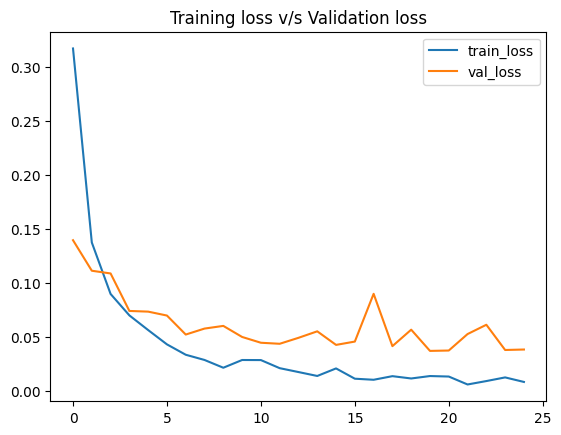

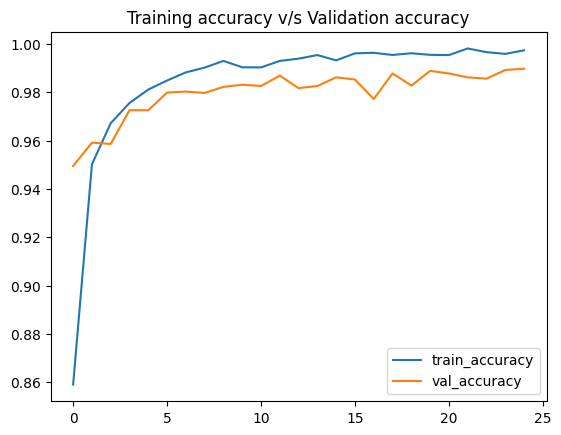

In [18]:
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.title('Training loss v/s Validation loss')
plt.show()

plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title("Training accuracy v/s Validation accuracy")
plt.show()

In [19]:
acc=model.evaluate(X_test,y_test,verbose=0)[1]
print(acc)

0.9888948798179626


In [20]:
# Evaluate Model on Test Data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_mat=classification_report(y_true, y_pred_classes)
print(conf_mat)


Test Accuracy: 98.89%
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2819
           1       0.99      0.99      0.99      2764

    accuracy                           0.99      5583
   macro avg       0.99      0.99      0.99      5583
weighted avg       0.99      0.99      0.99      5583



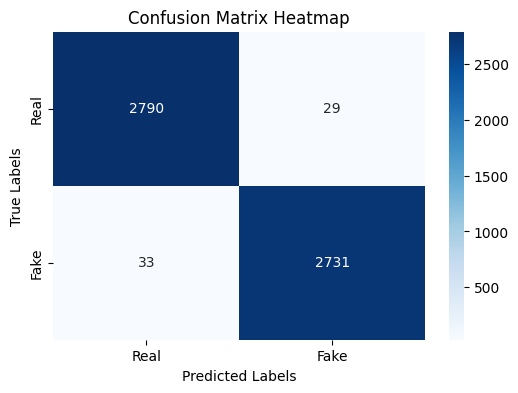

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred_classes)


class_labels = ["Real", "Fake"]


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)


plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [22]:
model.save("audio_classification_model.h5")

In [53]:
def predict_audio(file_path, model, scaler, max_timesteps=87, num_features=80):
    """
    Predict whether the audio is Real or Fake using the trained CNN-LSTM model.
    
    Parameters:
        file_path (str): Path to the audio file.
        model (tf.keras.Model): Trained Keras model.
        scaler (StandardScaler): Fitted scaler for feature normalization.
        max_timesteps (int): Max time steps used during training.
        num_features (int): Number of features (e.g., mel bins).
    
    Returns:
        str: "Real" or "Fake"
    """
    # Step 1: Extract Features
    features = extract_features(file_path)  # Shape: (timesteps, features)

    # Step 2: Check feature dimensions
    if features.shape[1] != num_features:
        raise ValueError(f"Feature mismatch. Expected {num_features}, got {features.shape[1]}.")

    # Step 3: Normalize with scaler
    features = scaler.transform(features)

    # Step 4: Pad to max_timesteps
    if features.shape[0] > max_timesteps:
        features = features[:max_timesteps, :]
    else:
        features = np.pad(features, ((0, max_timesteps - features.shape[0]), (0, 0)), mode='constant')

    # Step 5: Reshape to 4D input for model: (1, timesteps, features, 1)
    features = features.reshape(1,max_timesteps, num_features, 1)

    # Step 6: Predict
    prediction = model.predict(features)
    predicted_label = np.argmax(prediction, axis=1)[0]

    return "Fake" if predicted_label == 0 else "Real"
    
audio_path ="/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/fake/file10153.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav"
result = predict_audio(audio_path, model=model, scaler=scaler)
print(f"Prediction: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: Fake
